In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, cohen_kappa_score, confusion_matrix


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mdrifaturrahman33/levir-cd")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/levir-cd


In [8]:
ls /kaggle/input/levir-cd/'LEVIR CD'/train/A

train_100.png  train_181.png  train_261.png  train_341.png  train_421.png
train_101.png  train_182.png  train_262.png  train_342.png  train_422.png
train_102.png  train_183.png  train_263.png  train_343.png  train_423.png
train_103.png  train_184.png  train_264.png  train_344.png  train_424.png
train_104.png  train_185.png  train_265.png  train_345.png  train_425.png
train_105.png  train_186.png  train_266.png  train_346.png  train_426.png
train_106.png  train_187.png  train_267.png  train_347.png  train_427.png
train_107.png  train_188.png  train_268.png  train_348.png  train_428.png
train_108.png  train_189.png  train_269.png  train_349.png  train_429.png
train_109.png  train_18.png   train_26.png   train_34.png   train_42.png
train_10.png   train_190.png  train_270.png  train_350.png  train_430.png
train_110.png  train_191.png  train_271.png  train_351.png  train_431.png
train_111.png  train_192.png  train_272.png  train_352.png  train_432.png
train_112.png  train_193.png  train_273

In [16]:
DATASET_PATH = "/kaggle/input/levir-cd/LEVIR CD/"        # <------------------------------------------this
TRAIN_IMG1_DIR = os.path.join(DATASET_PATH, 'train/A/')
TRAIN_IMG2_DIR = os.path.join(DATASET_PATH, 'train/B/')
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, 'train/label/')

VAL_IMG1_DIR = os.path.join(DATASET_PATH, 'val/A/')
VAL_IMG2_DIR = os.path.join(DATASET_PATH, 'val/B/')
VAL_MASK_DIR = os.path.join(DATASET_PATH, 'val/label/')

TEST_IMG1_DIR = os.path.join(DATASET_PATH, 'test/A/')
TEST_IMG2_DIR = os.path.join(DATASET_PATH, 'test/B/')
TEST_MASK_DIR = os.path.join(DATASET_PATH, 'test/label/')

In [17]:
IMG_SIZE = (1024, 1024)
BATCH_SIZE = 1
print(IMG_SIZE[0])

1024


In [18]:
def load_image(img1_path, img2_path, mask_path):
    img1 = tf.io.read_file(img1_path)
    img1 = tf.image.decode_png(img1, channels=3)
    img1 = tf.image.resize(img1, IMG_SIZE) / 255.0
    img2 = tf.io.read_file(img2_path)
    img2 = tf.image.decode_png(img2, channels=3)
    img2 = tf.image.resize(img2, IMG_SIZE) / 255.0
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE) / 255.0
    image = tf.concat([img1, img2], axis=-1)
    return image, mask

def get_dataset(img1_dir, img2_dir, mask_dir):
    img1_files = sorted([os.path.join(img1_dir, f) for f in os.listdir(img1_dir)])
    img2_files = sorted([os.path.join(img2_dir, f) for f in os.listdir(img2_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    dataset = tf.data.Dataset.from_tensor_slices((img1_files, img2_files, mask_files))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = get_dataset(TRAIN_IMG1_DIR, TRAIN_IMG2_DIR, TRAIN_MASK_DIR)
val_ds = get_dataset(VAL_IMG1_DIR, VAL_IMG2_DIR, VAL_MASK_DIR)
test_ds = get_dataset(TEST_IMG1_DIR, TEST_IMG2_DIR, TEST_MASK_DIR)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

I0000 00:00:1753098404.333292      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


445
64
128


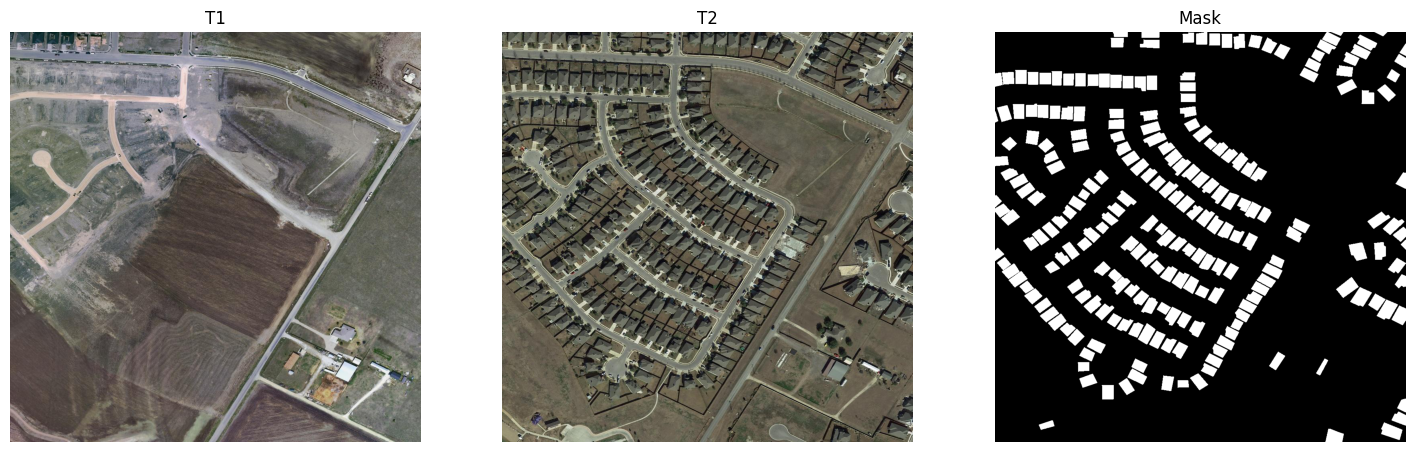

In [19]:
import cv2
import random

def display_example():
    idx = random.randint(0, len(os.listdir(TRAIN_IMG1_DIR)) - 1)
    img1_path = os.path.join(TRAIN_IMG1_DIR, os.listdir(TRAIN_IMG1_DIR)[idx])
    img2_path = os.path.join(TRAIN_IMG2_DIR, os.listdir(TRAIN_IMG2_DIR)[idx])
    mask_path = os.path.join(TRAIN_MASK_DIR, os.listdir(TRAIN_MASK_DIR)[idx])
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img1 = cv2.resize(img1, IMG_SIZE)
    img2 = cv2.resize(img2, IMG_SIZE)
    mask = cv2.resize(mask, IMG_SIZE)
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)); plt.title('T1'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.title('T2'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(mask, cmap='gray'); plt.title('Mask'); plt.axis('off')
    plt.show()

display_example()


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def bottleneck_block(x, filters_in, filters_mid, filters_out, stride=1, dilation=1, name=""):
    shortcut = x
    x = layers.Conv2D(filters_mid, 1, strides=1, padding='same', name=f"{name}_conv1")(x)
    x = layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = layers.ReLU(name=f"{name}_relu1")(x)

    x = layers.Conv2D(filters_mid, 3, strides=stride, padding='same', dilation_rate=dilation, name=f"{name}_conv2")(x)
    x = layers.BatchNormalization(name=f"{name}_bn2")(x)
    x = layers.ReLU(name=f"{name}_relu2")(x)

    x = layers.Conv2D(filters_out, 1, strides=1, padding='same', name=f"{name}_conv3")(x)
    x = layers.BatchNormalization(name=f"{name}_bn3")(x)

    if shortcut.shape[-1] != filters_out or stride != 1:
        shortcut = layers.Conv2D(filters_out, 1, strides=stride, padding='same', name=f"{name}_conv_shortcut")(shortcut)
        shortcut = layers.BatchNormalization(name=f"{name}_bn_shortcut")(shortcut)

    x = layers.Add(name=f"{name}_add")([x, shortcut])
    x = layers.ReLU(name=f"{name}_relu3")(x)
    return x

def stem_block(inputs):
    x = layers.Conv2D(64, 3, strides=2, padding='same', name="stem_conv1")(inputs)
    x = layers.BatchNormalization(name="stem_bn1")(x)
    x = layers.ReLU(name="stem_relu1")(x)

    x = layers.Conv2D(64, 3, strides=1, padding='same', name="stem_conv2")(x)
    x = layers.BatchNormalization(name="stem_bn2")(x)
    x = layers.ReLU(name="stem_relu2")(x)

    x = layers.Conv2D(128, 3, strides=1, padding='same', name="stem_conv3")(x)
    x = layers.BatchNormalization(name="stem_bn3")(x)
    x = layers.ReLU(name="stem_relu3")(x)

    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name="stem_pool")(x)
    return x

def cg_aspp(x):
    b1 = layers.Conv2D(256, 1, padding='same')(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.ReLU()(b1)

    b2 = layers.Conv2D(256, 3, padding='same', dilation_rate=6)(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.ReLU()(b2)

    b3 = layers.Conv2D(256, 3, padding='same', dilation_rate=12)(x)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.ReLU()(b3)

    b4 = layers.Conv2D(256, 3, padding='same', dilation_rate=18)(x)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.ReLU()(b4)

    b5 = layers.GlobalAveragePooling2D()(x)
    b5 = layers.Reshape((1, 1, -1))(b5)
    b5 = layers.Conv2D(256, 1, padding='same')(b5)
    b5 = layers.BatchNormalization()(b5)
    b5 = layers.ReLU()(b5)
    b5 = layers.Lambda(lambda args: tf.image.resize(args[0], tf.shape(args[1])[1:3]))([b5, x])

    out = layers.Concatenate()([b1, b2, b3, b4, b5])
    out = layers.Conv2D(256, 1, padding='same')(out)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)
    return out

def cifu_block(low_feat, high_feat):
    x = layers.Concatenate()([low_feat, high_feat])
    gap = layers.GlobalAveragePooling2D()(x)
    dense1 = layers.Dense(x.shape[-1] // 16, activation='relu')(gap)
    dense2 = layers.Dense(x.shape[-1], activation='sigmoid')(dense1)
    scale = layers.Reshape((1, 1, -1))(dense2)
    out = layers.Multiply()([x, scale])
    return out

def AGCDetNet(IMG_SIZE=(1024, 1024), channels=6):
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], channels))

    x = stem_block(inputs)

    x = bottleneck_block(x, 128, 64, 256, name="layer1_block1")
    x = bottleneck_block(x, 256, 64, 256, name="layer1_block2")
    x = bottleneck_block(x, 256, 64, 256, name="layer1_block3")
    low_level = x

    x = bottleneck_block(x, 256, 128, 512, stride=2, name="layer2_block1")
    for i in range(2, 5):
        x = bottleneck_block(x, 512, 128, 512, name=f"layer2_block{i}")

    for i in range(1, 7):
        x = bottleneck_block(x, 512 if i == 1 else 1024, 256, 1024, dilation=2, name=f"layer3_block{i}")

    coarse = layers.Conv2D(1, 1, activation='sigmoid')(x)
    coarse_up = layers.Lambda(lambda args: tf.image.resize(args[0], tf.shape(args[1])[1:3]))([coarse, low_level])

    for i in range(1, 4):
        x = bottleneck_block(x, 1024 if i == 1 else 2048, 512, 2048, dilation=4, name=f"layer4_block{i}")

    x = cg_aspp(x)

    spam = layers.Multiply()([x, coarse])
    spam = layers.Conv2D(256, 1, padding='same', activation='relu')(spam)
    spam = layers.BatchNormalization()(spam)
    spam_up = layers.Lambda(lambda args: tf.image.resize(args[0], tf.shape(args[1])[1:3]))([spam, low_level])

    low_proj = layers.Conv2D(64, 1, padding='same', activation='relu')(low_level)
    low_proj = layers.BatchNormalization()(low_proj)

    fused = cifu_block(low_proj, spam_up)

    out = layers.Conv2D(128, 3, padding='same', activation='relu')(fused)
    out = layers.BatchNormalization()(out)
    out = layers.Conv2D(64, 3, padding='same', activation='relu')(out)
    out = layers.BatchNormalization()(out)
    out = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(out)
    out = layers.Resizing(IMG_SIZE[0], IMG_SIZE[1])(out)

    model = Model(inputs, out, name="AGCDetNet")
    return model

# Define IMG_SIZE if needed
IMG_SIZE = (1024, 1024)

# Instantiate the model safely
model = AGCDetNet(IMG_SIZE=IMG_SIZE, channels=6)

# Optionally print summary to verify structure
model.summary()


Model: "AGCDetNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 6)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 512, 512,  │      3,520 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 512, 512,  │        256 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu1 (ReLU)   │ (None, 512, 512,  │          0 │ stem_bn1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv2 (Conv2D) │ (None, 512, 512,  │     36,928 │ stem_relu1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn2            │ (None, 512, 512,  │        256 │ stem_conv2[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu2 (ReLU)   │ (None, 512, 512,  │          0 │ stem_bn2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv3 (Conv2D) │ (None, 512, 512,  │     73,856 │ stem_relu2[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn3            │ (None, 512, 512,  │        512 │ stem_conv3[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_relu3 (ReLU)   │ (None, 512, 512,  │          0 │ stem_bn3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 256, 256,  │          0 │ stem_relu3[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_conv1 │ (None, 256, 256,  │      8,256 │ stem_pool[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_bn1   │ (None, 256, 256,  │        256 │ layer1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_relu1 │ (None, 256, 256,  │          0 │ layer1_block1_bn… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_conv2 │ (None, 256, 256,  │     36,928 │ layer1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_bn2   │ (None, 256, 256,  │        256 │ layer1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_relu2 │ (None, 256, 256,  │          0 │ layer1_block1_bn

 Total params: 39,794,582 (151.80 MB)

 Trainable params: 39,736,982 (151.58 MB)

 Non-trainable params: 57,600 (225.00 KB)

In [27]:
import tensorflow as tf

def soft_jaccard_loss(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return 1 - jac

def agcdetnet_loss(y_true, y_pred, lambda_c=0.4, lambda_s=0.2):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    jaccard = soft_jaccard_loss(y_true, y_pred)
    main_loss = bce + jaccard

    coarse_loss = bce
    spam_loss = bce

    total_loss = main_loss + lambda_c * coarse_loss + lambda_s * spam_loss
    return total_loss


In [30]:
from tensorflow.keras import callbacks

checkpoint_cb = callbacks.ModelCheckpoint(
    '06_AGCD_again.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reducelr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=10,
    factor=0.5,
    verbose=1
)


In [31]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)


Epoch 1/50


I0000 00:00:1753098818.618630     101 service.cc:148] XLA service 0x7f949c001d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753098818.619805     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753098824.333638     101 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1753098829.687162     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753098829.943060     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1753098871.103518     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8522 - loss: 1.5449
Epoch 1: val_loss improved from inf to 1.20856, saving model to 06_AGCD_again.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 358s 555ms/step - accuracy: 0.8524 - loss: 1.5442 - val_accuracy: 0.9537 - val_loss: 1.2086 - learning_rate: 0.0010
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9571 - loss: 0.9075
Epoch 2: val_loss improved from 1.20856 to 1.05917, saving model to 06_AGCD_again.weights.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 242s 542ms/step - accuracy: 0.9571 - loss: 0.9076 - val_accuracy: 0.9609 - val_loss: 1.0592 - learning_rate: 0.0010
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9633 - loss: 0.8299
Epoch 3: val_loss did not improve from 1.05917
445/445 ━━━━━━━━━━━━━━━━━━━━ 239s 537ms/step - accuracy: 0.9633 - loss: 0.8299 - val_accuracy: 0.9463 - val_loss: 1.0766 - learning_rate: 0.0010
Epoch 4/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9687 - loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


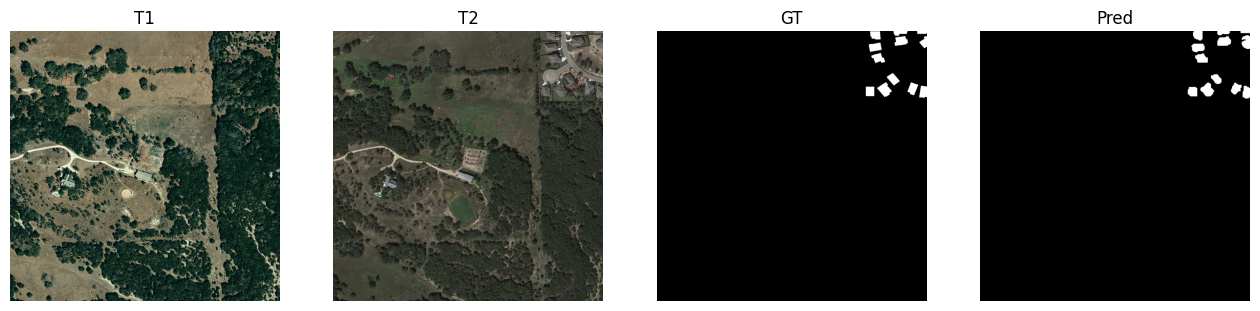

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


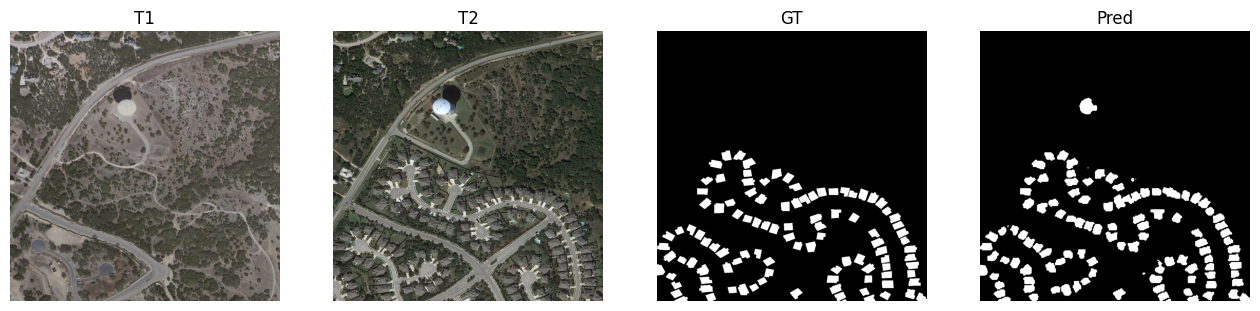

In [32]:
def visualize_preds(ds, model, samples=3):
    for imgs, masks in ds.take(samples):
        preds = model.predict(imgs)
        n = min(samples, imgs.shape[0])
        for i in range(n):
            plt.figure(figsize=(16,4))
            plt.subplot(1,4,1); plt.imshow(imgs[i,...,:3]); plt.title('T1'); plt.axis('off')
            plt.subplot(1,4,2); plt.imshow(imgs[i,...,3:6]); plt.title('T2'); plt.axis('off')
            plt.subplot(1,4,3); plt.imshow(masks[i,...,0], cmap='gray'); plt.title('GT'); plt.axis('off')
            plt.subplot(1,4,4); plt.imshow(preds[i,...,0]>0.5, cmap='gray'); plt.title('Pred'); plt.axis('off')
            plt.show()

visualize_preds(test_ds, model, samples=2)


In [33]:
y_true, y_pred = [], []

for imgs, masks in test_ds:
    preds = model.predict(imgs)
    preds_bin = (preds > 0.5).astype(np.uint8)
    masks_bin = (masks.numpy() > 0.5).astype(np.uint8)
    y_true.extend(masks_bin.flatten())
    y_pred.extend(preds_bin.flatten())

print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision :", precision_score(y_true, y_pred))
print("Recall :", recall_score(y_true, y_pred))
print("F1 Score :", f1_score(y_true, y_pred))
print("Jaccard Index :", jaccard_score(y_true, y_pred))
print("Cohen's Kappa :", cohen_kappa_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 